In [ ]:
import random
import numpy as np
import pandas as pd
random.seed(3311791)
np.random.seed(3311791)
df = pd.read_csv('/kaggle/input/df-lemma-clean/df_lemma_dropped.csv').drop('H', axis=1)
df['Year'] = df['Year'].astype(int)

In [ ]:
!pip install umap-learn hdbscan
!pip install BorutaShap
!pip install xlsxwriter
!pip install adjustText
from adjustText import adjust_text
from BorutaShap import BorutaShap
import umap
import hdbscan
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=1a8e1e7ed15f339877de2ffb0f617f055f43ed783bc71a75c4925064ff0a9f7b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.0 MB/s eta 0:00:

2024-04-17 22:35:30.598963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 22:35:30.599093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 22:35:30.724376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def umap_hdbscan_plot(df_plt):
    cmap = plt.cm.get_cmap('tab10', len(df_plt['cluster'].unique()))

    plt.figure(figsize=(10, 7))
    plt.scatter(df_plt['dim_1'], df_plt['dim_2'], color=cmap(df_plt['cluster']))

    # Get unique clusters
    unique_clusters = df_plt['cluster'].unique()
    random_clusters = random.sample(list(unique_clusters), 5)

    texts = []
    for cluster in random_clusters:
            cluster_points = df_plt[df_plt['cluster'] == cluster]
            sample_points = cluster_points.sample(min(3, len(cluster_points)))

            for i, point in sample_points.iterrows():
                    texts.append(plt.text(point['dim_1'], point['dim_2'], i, color=cmap(df_plt['cluster'][i])))

    adjust_text(texts)

    handles = [mpatches.Patch(color=cmap(df_plt['cluster'].max()), label='Noise')]
    plt.legend(handles=handles)
    plt.title('HDBSCAN clustering with UMAP embeddings')
    plt.show()


In [ ]:
import matplotlib.patches as mpatches

def get_clustered_cooc_dfs(tfidf_dummy, n_components, min_cluster_size=5):
        #UMAP and HDBSCAN
        reducer = umap.UMAP(metric='hamming', n_components=n_components, random_state=0)
        embedding = reducer.fit_transform(tfidf_dummy.T)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        clusters = clusterer.fit_predict(embedding)

        col_names = [f'dim_{i}' for i in range(1, n_components + 1)]
        df_plt = pd.DataFrame(embedding, columns=col_names) # ['x', 'y', 'z'])
        df_plt['cluster'] = clusters
        df_plt['cluster'] = df_plt['cluster'].replace(-1, df_plt['cluster'].max() + 1)
        df_plt.index = tfidf_dummy.columns
        df_plt.to_csv(f'df_plt_{start}_{stop}.csv')

        noise = df_plt['cluster'].max()
        filtered_df_plt = df_plt[df_plt['cluster'] != noise]
        noise_df = df_plt[df_plt['cluster'] == noise]
        noise_dummy = tfidf_dummy[noise_df.index].copy()

        cluster_dummy = tfidf_dummy[filtered_df_plt.index].copy()
        cluster_dummy.columns = pd.MultiIndex.from_arrays([filtered_df_plt['cluster'], cluster_dummy.columns], names=['cluster', 'variable'])
        cluster_dict = {cluster: list(cluster_dummy.columns[cluster_dummy.columns.get_level_values('cluster') == cluster].get_level_values('variable')) for cluster in cluster_dummy.columns.levels[0]}

        cluster_dummy_grouped = cluster_dummy.groupby(level='cluster', axis=1).sum()
        cluster_dummy_grouped.columns = [f'cluster_{cluster}' for cluster in cluster_dummy_grouped.columns]
        cluster_dummy_grouped[cluster_dummy_grouped > 1] = 1

        umap_hdbscan_plot(df_plt)

        return noise_dummy, cluster_dummy_grouped, cluster_dict


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=5) 

def run_BorutaShap(df, cluster_noise_control_dummy, n_try, perc=99):

    y = df['Number.of.Forward.Citations']
    X = cluster_noise_control_dummy
    print(f'Shape of X: {X.shape}')

    Feature_Selector_shap = BorutaShap(model=rf, importance_measure='shap',
                                  classification=False, percentile=perc)
    Feature_Selector_shap.fit(X=X, y=y, n_trials=n_try, sample=True,
                          train_or_test = 'train', normalize=True,
                verbose=False, random_state=0)
    Feature_Selector_shap.TentativeRoughFix()
    return Feature_Selector_shap

In [ ]:
def find_top_sentences(file, tfidf_dummy, df_time_period, cluster_dict, n=20):
    results_df = pd.DataFrame()
    feat_imps = pd.read_csv(file)
    feat_imps = feat_imps[(~feat_imps['Features'].str.contains('Shadow') & feat_imps['Features'].str.contains('\+')) | feat_imps['Features'].str.contains('cluster_')]
    top_n_features = list(feat_imps.head(n)['Features'])

    for feature in top_n_features:
        if feature.startswith('cluster_'):
            cluster_num = int(feature.split('_')[1])
            variables = cluster_dict[cluster_num]

            for i, var in enumerate(variables):
                sentences = process_sentences(feature=var, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)
                sentences['cluster'] = cluster_num
                results_df = pd.concat([results_df, sentences])
        else:
            sentences = process_sentences(feature=feature, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)
            sentences['cluster'] = '-'
            results_df = pd.concat([results_df, sentences])

    out = results_df[['cluster','Number.of.Forward.Citations', 'Year', 'Title', 'both_words_sentences']]
    return out

import re
def process_sentences(feature, tfidf_dummy, df_time_period):#, start, stop):
        word_ngrams = feature.split('+')

        sentences = df_time_period[(tfidf_dummy[feature] == 1)]

        sentences = sentences[['Year', 'Text', 'Number.of.Forward.Citations', 'Title']]

        if len(feature.split('+')[0].split()) >= 2:
            sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[0][0:5] in sent.lower() and word_ngrams[1][0:5] in sent.lower() and ' '.join(word_ngrams).split()[1][0:5] in sent.lower()]))
        else:
            sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[1] in sent.lower() and word_ngrams[0] in sent.lower()]))
        # Set the index to the feature name
        sentences.index = [feature] * len(sentences)
        return sentences

def save_as_xlsx(results, start, stop):
    writer = pd.ExcelWriter(f'/kaggle/working/Coocurrence_sentences_{start}_{stop}.xlsx', engine='xlsxwriter')
    results[0].to_excel(writer, sheet_name=f'{start}_{stop}')
    workbook = writer.book

    wrap_format = workbook.add_format({'text_wrap': True})
    for sheet_name in [f'{start}_{stop}']:
        worksheet = writer.sheets[sheet_name]
        worksheet.set_column('A:Z', 20, wrap_format)
    writer.close()




Analyzing years 1920.0 - 1990...


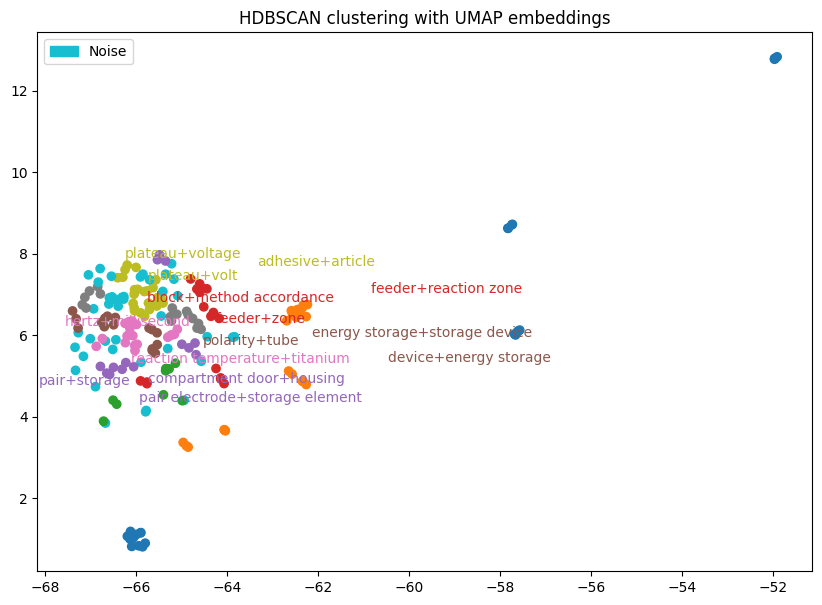

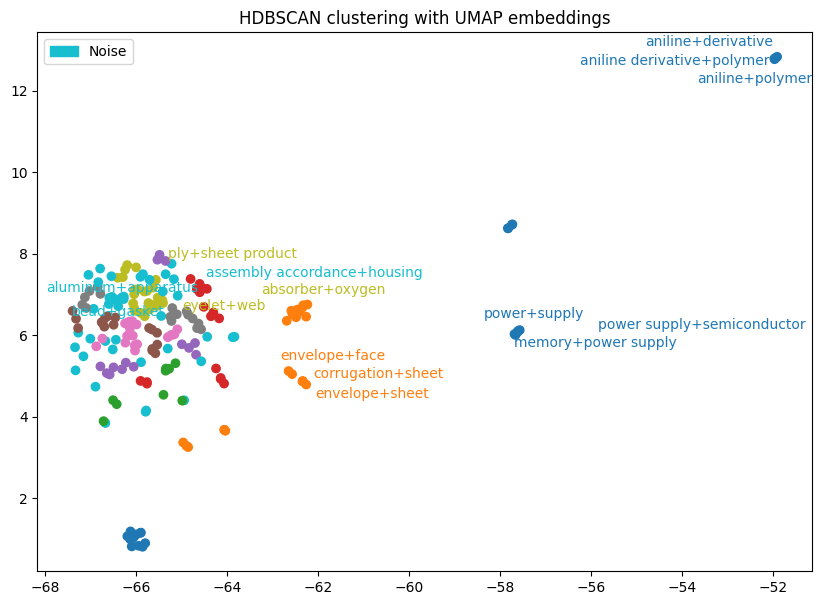

clustering took 5.204440116882324 seconds
shape cluster_noise_control_dummy: (1159, 23322)
Shape of X: (1159, 23322)


  0%|          | 0/50 [00:00<?, ?it/s]

34 attributes confirmed important: ['C', 'Family.Number_12130003', 'Country.Code_CA', 'Probable.Patent.Assignee_TOSHIBA BATTERY CO', 'Family.Number_1371103', 'Family.Number_4949380', 'Probable.Patent.Assignee_DU PONT', 'Probable.Patent.Assignee_TOCHIGI FUJI SANGYO KK', 'clutch+gear', 'Country.Code_EP', 'Family.Number_29803733', 'Patent_age_scaled', 'Family.Number_12212737', 'A', 'Family.Number_6327507', 'Probable.Patent.Assignee_OF CALIFORNIA UNIV', 'Probable.Patent.Assignee_SONY CORP', 'Family.Number_411218', 'Probable.Patent.Assignee_MOLI ENERGY 1990 A CANADIAN CORP LTD', 'Family.Number_1122088', 'Country.Code_US', 'Probable.Patent.Assignee_CELGARD LLC', 'Probable.Patent.Assignee_LUBRIZOL ENTERPRISES INC', 'Family.Number_2076591', 'Family.Number_15154776', 'D', 'Family.Number_10871807', 'Family.Number_4098101', 'Probable.Patent.Assignee_CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE', 'Family.Number_12352906', 'Grant_dummy', 'cluster_25', 'bath+pyrrole', 'Family.Number_3309004']
23281 

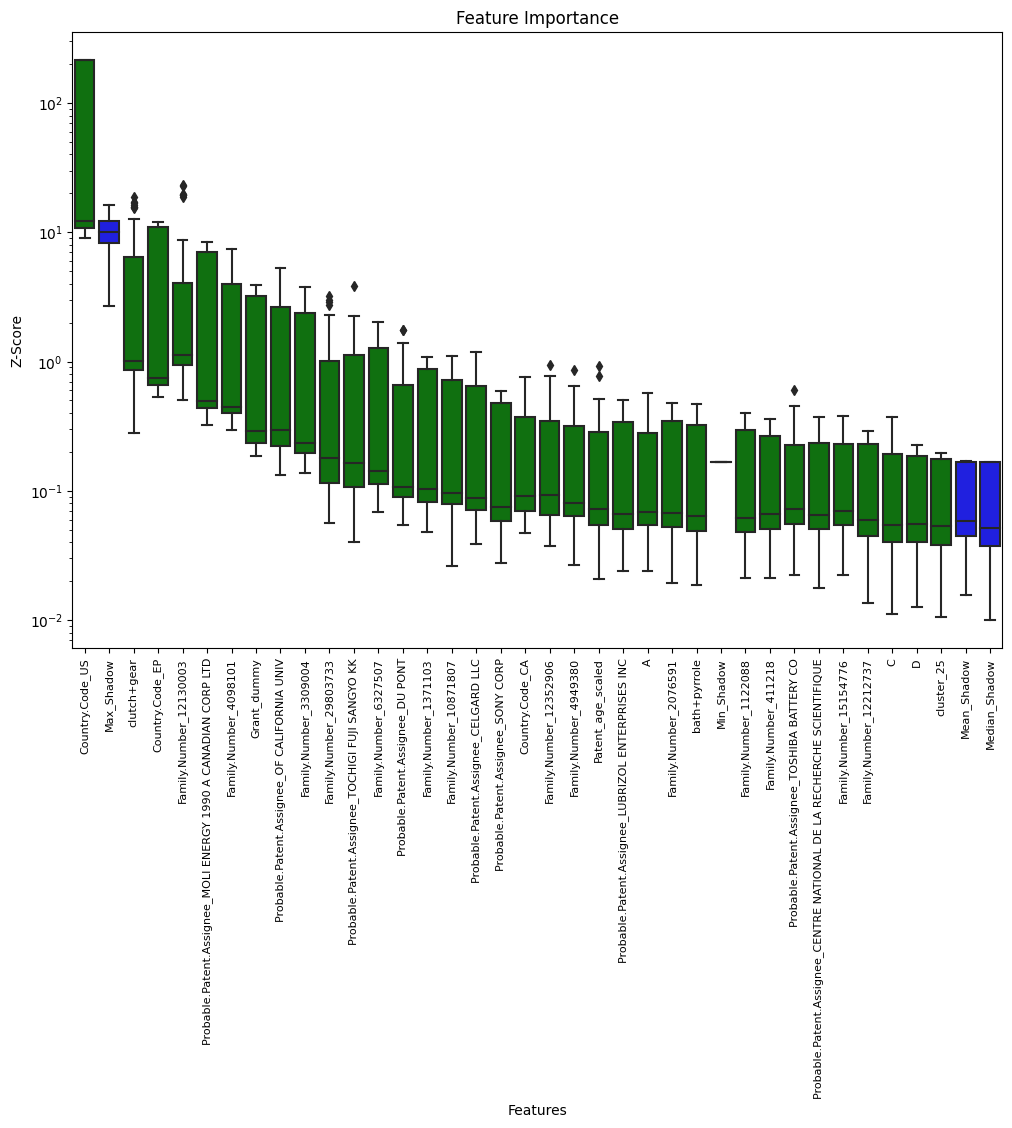

find_top_sentences took 0.7644796371459961 seconds
Analyzing years 1991 - 2008...


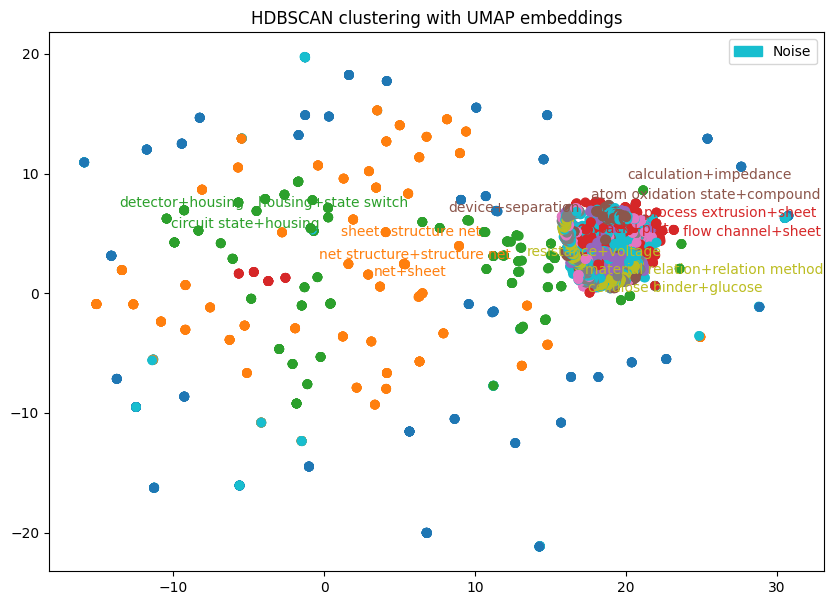

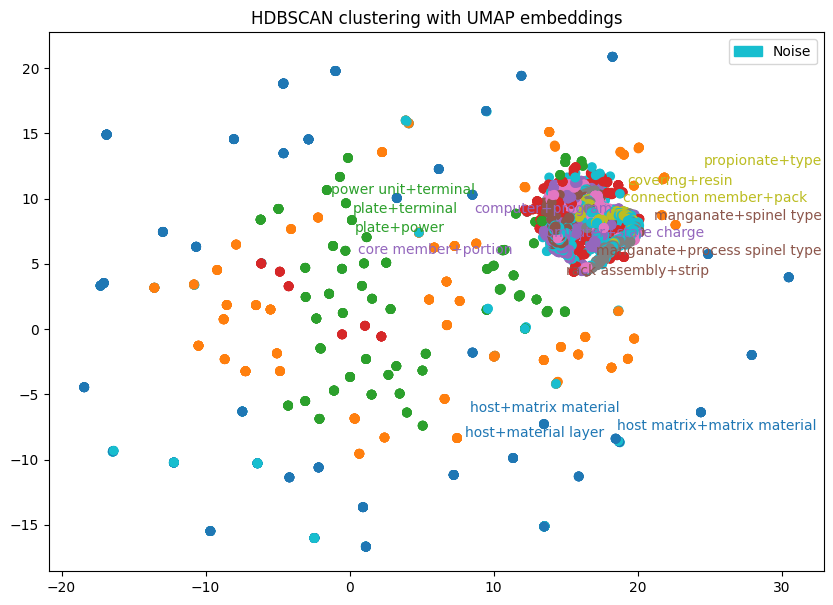

clustering took 145.09604620933533 seconds
shape cluster_noise_control_dummy: (10938, 24419)
Shape of X: (10938, 24419)


  0%|          | 0/50 [00:00<?, ?it/s]

32 attributes confirmed important: ['Family.Number_40843664', 'C', 'cluster_221', 'Probable.Patent.Assignee_POLYPLUS BATTERY CO', 'Family.Number_33397880', 'Country.Code_GB', 'Family.Number_15561860', 'Family.Number_30013487', 'Family.Number_31882118', 'Family.Number_28192634', 'Probable.Patent.Assignee_ULTRALIFE BATTERIES INC', 'Family.Number_11789189', 'Country.Code_EP', 'Patent_age_scaled', 'Family.Number_33351941', 'Family.Number_23353609', 'Probable.Patent.Assignee_COVIDIEN LP', 'Country.Code_WO', 'anode+cathode', 'Family.Number_33671343', 'Probable.Patent.Assignee_NEXEON LTD', 'particle+separator', 'Country.Code_US', 'Family.Number_42664703', 'Probable.Patent.Assignee_BRASSELER USA MEDICAL LLC', 'Family.Number_12191304', 'Probable.Patent.Assignee_EAGLEPICHER TECHNOLOGIES LLC', 'Family.Number_28190172', 'Probable.Patent.Assignee_HYDRO QUEBEC', 'Grant_dummy', 'Family.Number_11205398', 'cluster_408']
24376 attributes confirmed unimportant: ['Family.Number_42802462', 'Family.Number_2

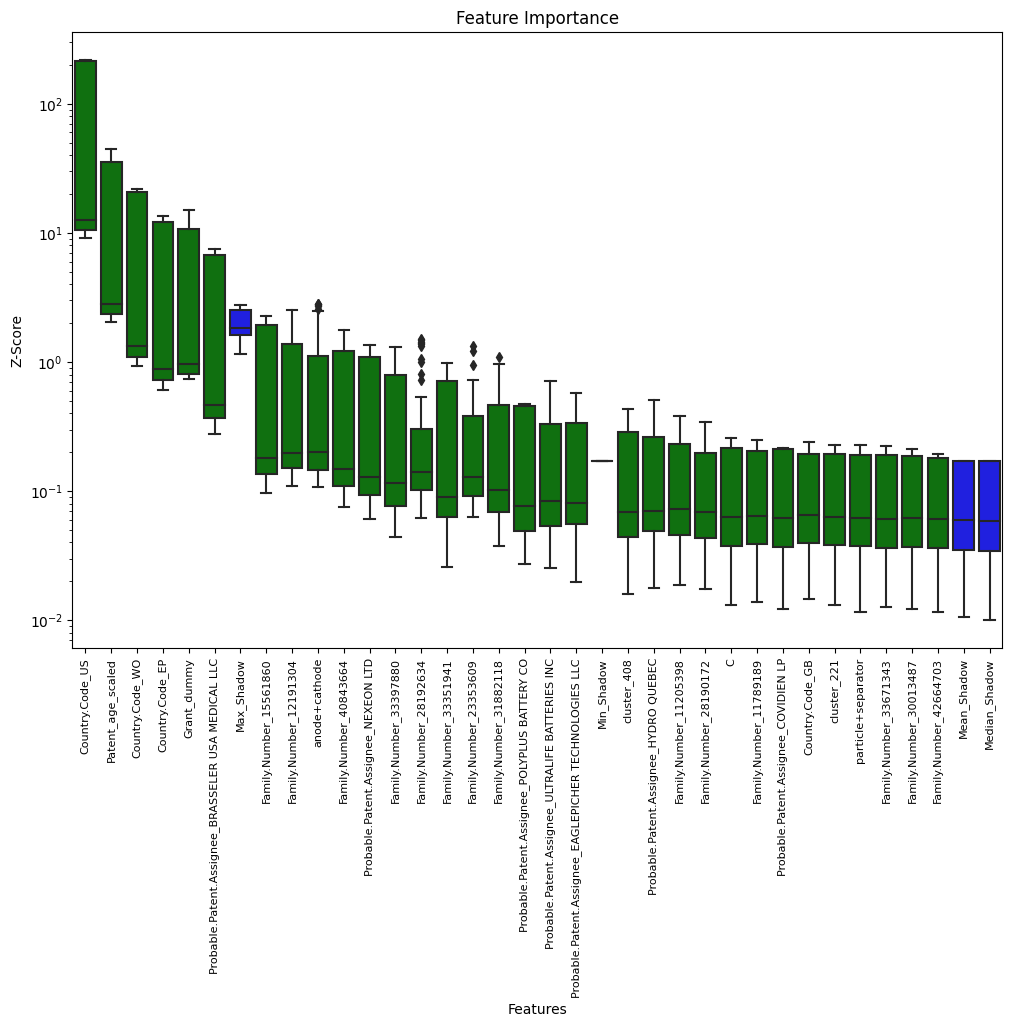

find_top_sentences took 1.7371997833251953 seconds
Analyzing years 2009 - 2016...


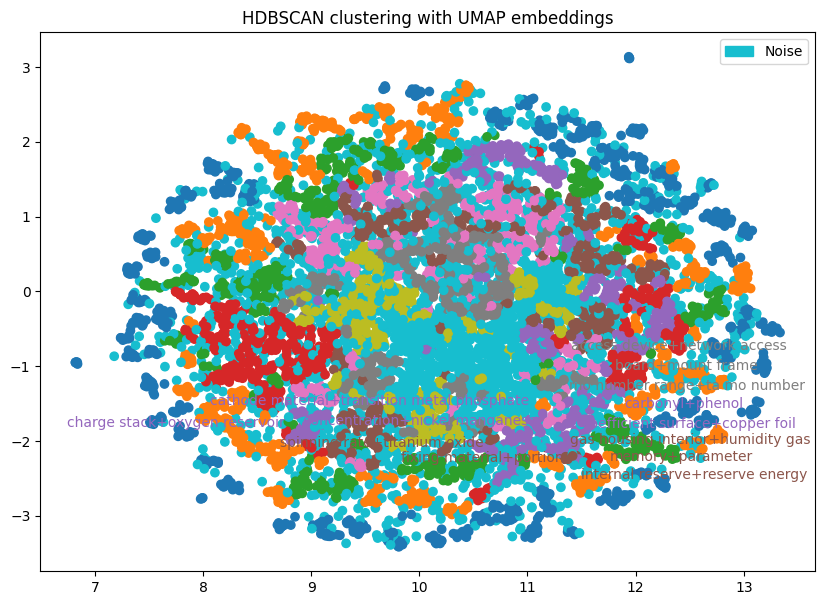

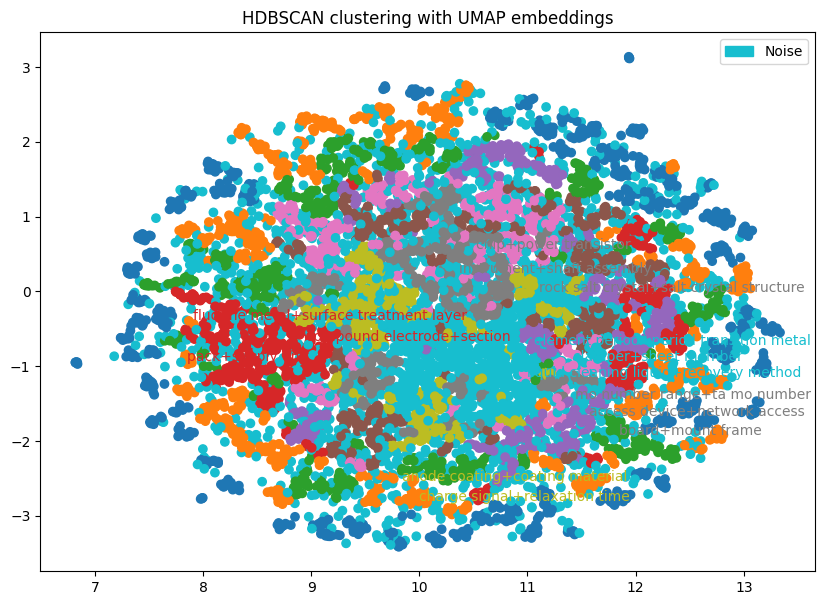

clustering took 75.69187045097351 seconds


KeyboardInterrupt: 

In [ ]:
import time
from sklearn.preprocessing import StandardScaler
import csv


df['Grant_dummy'] = df['Grant'].replace({'YES': 1, 'NO': 0})
control_variables = ['Country.Code', 'Probable.Patent.Assignee', 'Family.Number', 'Grant_dummy', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
df['Application.Date'] = pd.to_datetime(df['Application.Date'])
df['Patent_age'] = df['Application.Date'].dt.year - df['Application.Date'].dt.year.min()

def main(df, time_periods=[(1990,1991)], start=None, stop=None, max_df=0.50, max_feat=None, min_patent_cooc=2, tfidf_threshold_percentile=99, min_cluster_size=2, n_components=50, n_try=60):
    '''
    Main function: outputs csv files from BorutaShap and sentences of most important co-occurrences as a xlsx file
    '''
    scaler = StandardScaler()
    results = []
    filenames = []

    dummy_cols = [col for col in control_variables if df[col].nunique() <= 2]

    non_dummy_controls = df[df[control_variables].columns[df[control_variables].nunique() >2]]
    dummy_controls = df[df[control_variables].columns[df[control_variables].nunique() <=2]]
    control_dummies = pd.concat([pd.get_dummies(non_dummy_controls), dummy_controls], axis=1)

    for i, (start, stop) in enumerate(time_periods):
        df_time_period = df[(df['Year'] >= start) & (df['Year'] <= stop)]
        control_dummies_time_period = control_dummies[(df['Year'] >= start) & (df['Year'] <= stop)].reset_index(drop=True)
        control_dummies_time_period['Patent_age_scaled'] = scaler.fit_transform(df_time_period[['Patent_age']])

   #     tfidf_dummy = get_tfidf_dummy(df_time_period, max_df=max_df, max_feat=max_feat, min_patent_cooc=min_patent_cooc, tfidf_threshold_percentile=tfidf_threshold_percentile)
        tfidf_dummy = pd.read_csv(f'tfidf_dummy_{start}_{stop}_maxdf{max_df}_tfidfperc{tfidf_threshold_percentile}.csv').drop('Unnamed: 0', axis=1)
        noise_dummy, cluster_dummy_grouped, cluster_dict = get_clustered_cooc_dfs(tfidf_dummy, min_cluster_size=min_cluster_size, n_components=n_components) # noise=non-clustered co-occurrences


        start_time = time.time()
        noise_dummy, cluster_dummy_grouped, cluster_dict = get_clustered_cooc_dfs(tfidf_dummy, min_cluster_size=min_cluster_size, n_components=n_components) # noise=non-clustered co-occurrences
        print(f'clustering took {time.time() - start_time} seconds')
        # save cluster_dict as csv
        with open(f'cluster_dict{start}_{stop}.csv', 'w') as f:
            writer = csv.writer(f)
            for key, value in cluster_dict.items():
                writer.writerow([key, value])

        cluster_noise_control_dummy = pd.concat([control_dummies_time_period, noise_dummy, cluster_dummy_grouped], axis=1)
        cluster_noise_control_dummy.to_csv(f'cluster_noise_control_dummy_{start}_{stop}.csv')
        print(f'shape cluster_noise_control_dummy: {cluster_noise_control_dummy.shape}')


        #BorutaShap importances
        # Run BorutaShap for the current time period
        start_time = time.time()
        Feature_Selector_shap = run_BorutaShap(df=df_time_period, cluster_noise_control_dummy=cluster_noise_control_dummy, perc=99, n_try=n_try)#start=start, stop=stop,
        print(f'BorutaShap took {time.time() - start_time} seconds')

        Feature_Selector_shap.plot(which_features='accepted')
        filename = f'feature_importance_{start}_to_{stop}'#.csv'

        Feature_Selector_shap.results_to_csv(filename=filename)

        filenames.append(filename)

        start_time = time.time()
        result = find_top_sentences(file= filenames[i]+'.csv', tfidf_dummy=tfidf_dummy, df_time_period=df_time_period.reset_index(drop=True), cluster_dict=cluster_dict)# + '.csv' #, start=start, stop=stop)
        print(f'find_top_sentences took {time.time() - start_time} seconds')

        results.append(result)
    #for (start, stop) in time_periods:
        save_as_xlsx(results, start, stop)

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))]
#time_periods = [(2000,2001)]
for start, stop in time_periods:
    print(f'Analyzing years {start} - {stop}...')
    main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)


Analyzing years 2009 - 2016...
shape cluster_noise_control_dummy: (21303, 26235)
Shape of X: (21303, 26235)


  0%|          | 0/50 [00:00<?, ?it/s]

0 tentative features are now accepted: []
23 tentative features are now rejected: ['control unit+sensor' 'mood+voice' 'mood mood+voice input' 'cluster_776'
 'G' 'cluster_780' 'assembly+transducer' 'cluster_735' 'cluster_449'
 'cluster_763' 'handle assembly+transmission' 'cluster_512' 'cluster_258'
 'cluster_979' 'Family.Number_52217330'
 'Probable.Patent.Assignee_ZOLL CIRCULATION INC'
 'instrument+power source power' 'cluster_737'
 'Probable.Patent.Assignee_COVIDIEN LP' 'cluster_83' 'cluster_841'
 'cluster_1075' 'cluster_758']
BorutaShap took 17494.72540807724 seconds


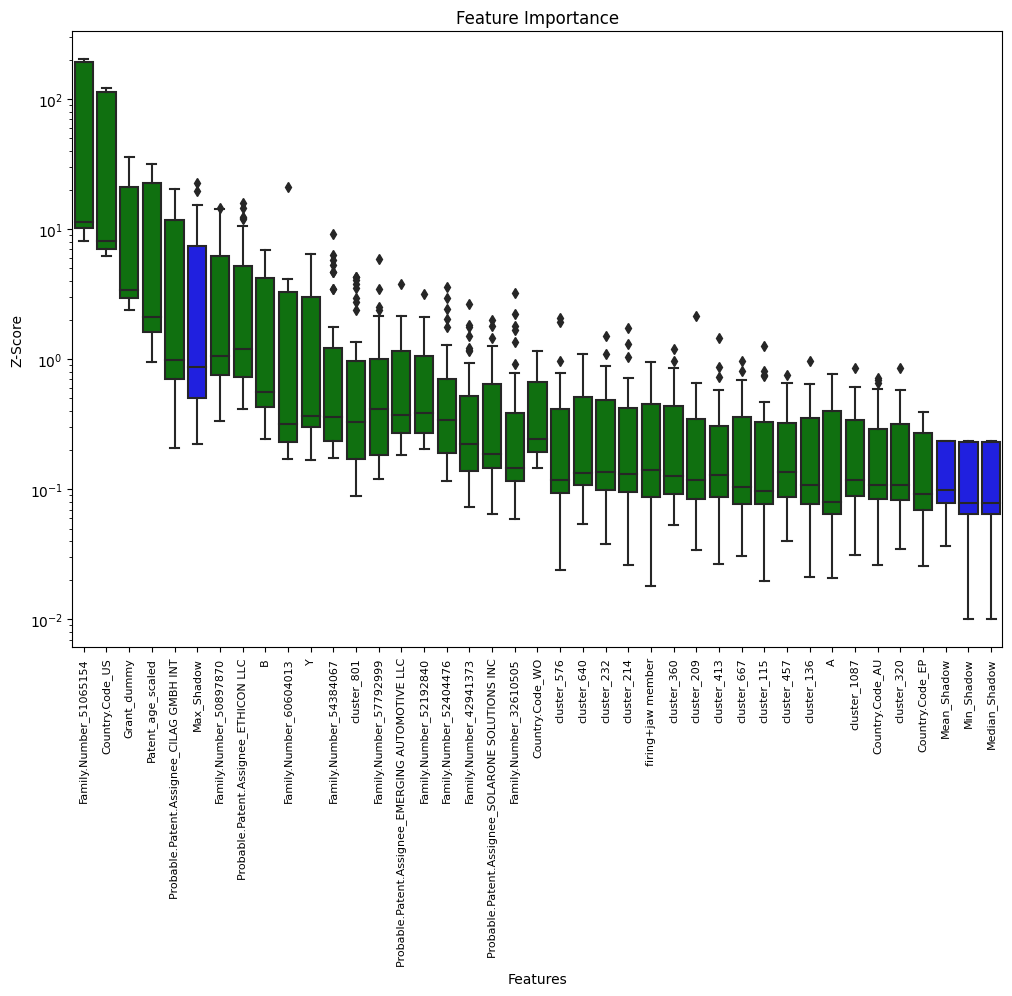

KeyError: '['

In [ ]:
#2009-2016
import time
from sklearn.preprocessing import StandardScaler
import csv
df['Grant_dummy'] = df['Grant'].replace({'YES': 1, 'NO': 0})
control_variables = ['Country.Code', 'Probable.Patent.Assignee', 'Family.Number', 'Grant_dummy', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
df['Application.Date'] = pd.to_datetime(df['Application.Date'])
df['Patent_age'] = df['Application.Date'].dt.year - df['Application.Date'].dt.year.min()
with open('/kaggle/input/2009-2016/cluster_dict2009_2016.csv', 'r') as f:
    reader = csv.reader(f)
    cluster_dict = {int(rows[0]):rows[1] for rows in reader}
cluster_noise_control_dummy = pd.read_csv('/kaggle/input/2009-2016/cluster_noise_control_dummy_2009_2016.csv').drop('Unnamed: 0', axis=1)
tfidf_dummy = pd.read_csv('/kaggle/input/2009-2016/tfidf_dummy_2009_2016_maxdf0.5_tfidfperc99.csv').drop('Unnamed: 0', axis=1)

def main(df, time_periods=[(1990,1991)], start=None, stop=None, max_df=0.50, max_feat=None, min_patent_cooc=2, tfidf_threshold_percentile=99, min_cluster_size=2, n_components=50, n_try=60):
    '''
    Main function: outputs csv files from BorutaShap and sentences of most important co-occurrences as a xlsx file
    '''
    scaler = StandardScaler()
    results = []
    filenames = []

    for i, (start, stop) in enumerate(time_periods):

        df_time_period = df[(df['Year'] >= start) & (df['Year'] <= stop)]
        print(f'shape cluster_noise_control_dummy: {cluster_noise_control_dummy.shape}')


        #BorutaShap importances
        # Run BorutaShap for the current time period
        start_time = time.time()
        Feature_Selector_shap = run_BorutaShap(df=df_time_period, cluster_noise_control_dummy=cluster_noise_control_dummy, perc=99, n_try=n_try)#start=start, stop=stop,
        print(f'BorutaShap took {time.time() - start_time} seconds')
        #del cluster_noise_control_dummy

        Feature_Selector_shap.plot(which_features='accepted')
        filename = f'feature_importance_{start}_to_{stop}'#.csv'

        Feature_Selector_shap.results_to_csv(filename=filename)

        filenames.append(filename)

        start_time = time.time()
        result = find_top_sentences(file= filenames[i]+'.csv', tfidf_dummy=tfidf_dummy, df_time_period=df_time_period.reset_index(drop=True), cluster_dict=cluster_dict)# + '.csv' #, start=start, stop=stop)
        print(f'find_top_sentences took {time.time() - start_time} seconds')

        results.append(result)

        save_as_xlsx(results, start, stop)

time_periods = [(2009, 2016)]

for start, stop in time_periods:
    print(f'Analyzing years {start} - {stop}...')
    main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)
